In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import sklearn as sk

c:\Users\Admin\anaconda3\envs\quant\Lib\site-packages\yfinance\scrapers\history.py:204: Pandas4Warning: Timestamp.utcnow is deprecated and will be removed in a future version. Use Timestamp.now('UTC') instead.
  dt_now = pd.Timestamp.utcnow()
[*********************100%***********************]  1 of 1 completed

Coefficient: [-7.46592043e-05]
Intercept: 0.006479807688441378
R2: 0.00


Price,Date,Close,High,Low,Open,Volume,Close + 5,Target,RSI
13,1993-02-18,23.948303,24.241407,23.620717,24.241407,378100,24.465538,0.021598,41.747837
14,1993-02-19,24.034498,24.034498,23.913808,23.948291,34900,24.500042,0.019370,44.444319
15,1993-02-22,24.120716,24.155199,24.034509,24.103475,513600,24.431063,0.012866,41.747586
16,1993-02-23,24.103487,24.206935,23.982797,24.189694,373700,24.793142,0.028612,39.604484
17,1993-02-24,24.413820,24.413820,24.120716,24.120716,26300,24.896595,0.019775,41.346016
...,...,...,...,...,...,...,...,...,...
8308,2026-02-02,695.409973,696.929993,689.419983,689.580017,79286500,693.950012,-0.002099,50.270504
8309,2026-02-03,689.530029,696.960022,684.030029,696.210022,107904600,692.119995,0.003756,45.818546
8310,2026-02-04,686.190002,691.450012,681.760010,690.349976,105204600,691.960022,0.008409,45.881901
8311,2026-02-05,677.619995,683.690002,675.789978,680.940002,113610800,681.270020,0.005387,37.247027


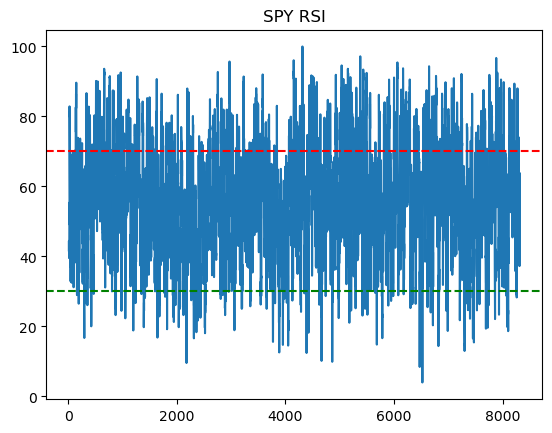

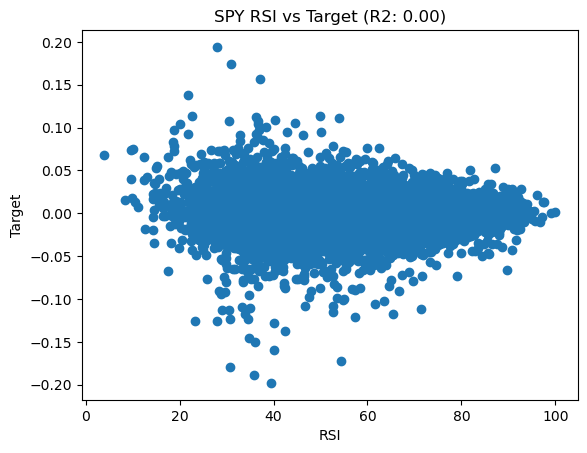

In [ ]:
ticker = "SPY"
interval = '1d'

#set period based on interval
if interval == '1h':
    period = "730d"
else:
    period = "max"

LOOKBACK = -10000
SHIFT=5

RSI_LENGTH = 14
OVERBOUGHT = 70
OVERSOLD = 30

def get_data(ticker, lookback=LOOKBACK, interval=interval, period=period):
    df = yf.download(ticker, period = period, auto_adjust=True, interval=interval)
    #reset index to get datetime as a column
    df = df.reset_index()

    df.sort_index(inplace=True)
    df.columns = df.columns.get_level_values(0)

    #only return data after lookback
    return df.iloc[lookback:,:]

#define the target variable (also called dependent variable, or y )
def add_target(df, shift=SHIFT):

    df[f'Close + {shift}'] = df['Close'].shift(-shift)

    #what is the change in  close price SHIFT days from now?
    df['Target'] = (df[f'Close + {shift}'] - df['Close']) / df['Close']
    return df

def add_RSI_feature(df, RSI_LENGTH):

    delta = df['Close'].diff()

    #separate gains and losses
    gain = (delta.where(delta > 0, 0))
    loss = (-delta.where(delta < 0, 0))

    #calculate average gain and loss
    avg_gain = gain.rolling(window=RSI_LENGTH).mean()
    avg_loss = loss.rolling(window=RSI_LENGTH).mean()

    #calculate RSI
    rs = avg_gain / avg_loss 
    df['RSI'] = 100 - (100 / (1 + rs))

    #plot RSI
    plt.figure()
    plt.plot(df['RSI'])
    plt.axhline(OVERBOUGHT, color='red', linestyle='--')    
    plt.axhline(OVERSOLD, color='green', linestyle='--')
    plt.title(f'{ticker} RSI')

    return df.dropna()

def generate_regression_output(df, feature='RSI', target='Target'):
    
    subset = df[[feature,target]].dropna()

    # reshape for sklearn 
    x = subset[[feature]].dropna() #2d
    y = subset[target].dropna()  #1d

    model = sk.linear_model.LinearRegression()
    model.fit(x, y)

    # use the regression model to "predict" the target variable
    y_pred = model.predict(x)

    #what is the relationhip btw features and target?
    r2 = sk.metrics.r2_score(y, y_pred)

    #coef, intercept, r2..... mse  later on
    print(f'Coefficient: {model.coef_}')
    print(f'Intercept: {model.intercept_}')
    print(f'R2: {r2:.2f}')

    #plot a relationship btw feature and target
    plt.figure()
    plt.scatter(x, y)
    plt.xlabel(f'{feature}')
    plt.ylabel(f'{target}')
    plt.title(f'{ticker} {feature} vs {target} (R2: {r2:.2f})')

    return df
    

def main():
    df = get_data(ticker, lookback=LOOKBACK, interval=interval, period=period)
    df = add_target(df, shift=SHIFT)
    df = add_RSI_feature(df, RSI_LENGTH=RSI_LENGTH)
    df = generate_regression_output(df)
    return df

main()